In [39]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import collections
from importlib import reload
# local modules (the classes Lattice, BS)
from src import lattice
from src.lattice import *
from src import bs
from src.bs import *

In [40]:
%matplotlib notebook

In [41]:
def plot_avg_n_species_per_t(lattice, title='Avg number of species over time (for different grain sizes)'):
    # Plot mean species per area using "quadrats" sampling scheme
    assert lattice.data is not None, 'use Lattice.run(collect_data=True)'    
    t_max = lattice.data.shape[0]
    step_size = int(t_max / 100)
    for grain_size in range(1, max(lattice.dimensions)+1):
#     for grain_size in range(1, 4):
        means = []
        for t, species in enumerate(lattice.data[::step_size]):
            mean, std = lattice.avg_n_species(grain_size, species)
            means.append(mean)
        plt.plot(means, label='grain size: %i' % grain_size)
    plt.plot([0,t], [lattice.N_species, lattice.N_species], '--', label='Minimum N species')
    plt.legend()
    plt.margins(0)
    plt.xlabel('t (1/%i)' % step_size)
    plt.ylabel('Avg number of species')
    plt.title(title)
    plt.yscale('log')

# Experiments

In [42]:
reload(bs)
reload(lattice);

In [43]:
l = Lattice((10,10), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=0, migration_bias=1)
# %time l.run(2000, collect_data=False)
%time l.run(1000, collect_data=True)

CPU times: user 12.4 s, sys: 152 ms, total: 12.6 s
Wall time: 12.7 s


<IPython.core.display.Javascript object>


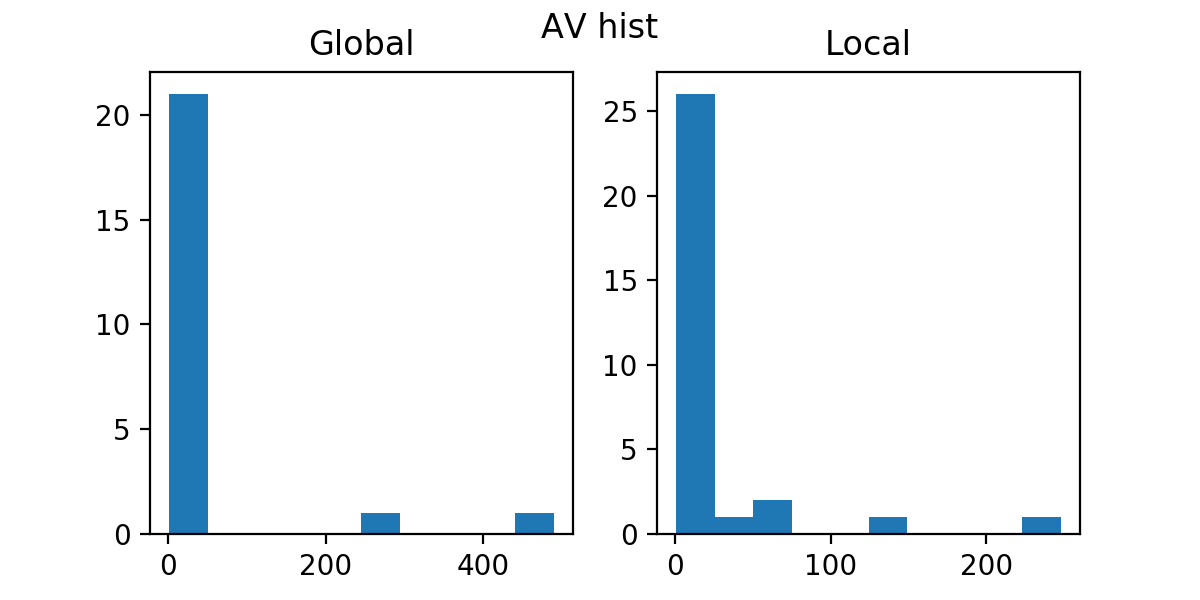

Text(0.5, 0.98, 'AV hist')

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
ax1.set_title('Global')
ax1.hist(l.av.trace[1:], bins=10)
ax2.set_title('Local') # sample size = 1
ax2.hist(l.av_local.trace[1:], bins=10)
plt.suptitle('AV hist')

In [37]:
# fig = plt.figure(figsize=(5,5))
# plt.plot(l.av.trace[1:], label='AV')
# plt.plot(l.av_local.trace[1:], label='AV local')
# plt.title('AV')
# plt.ylabel('AV size')
# plt.xlabel('t')
# plt.legend()
# plt.yscale('log')
# plt.margins(0)

<IPython.core.display.Javascript object>


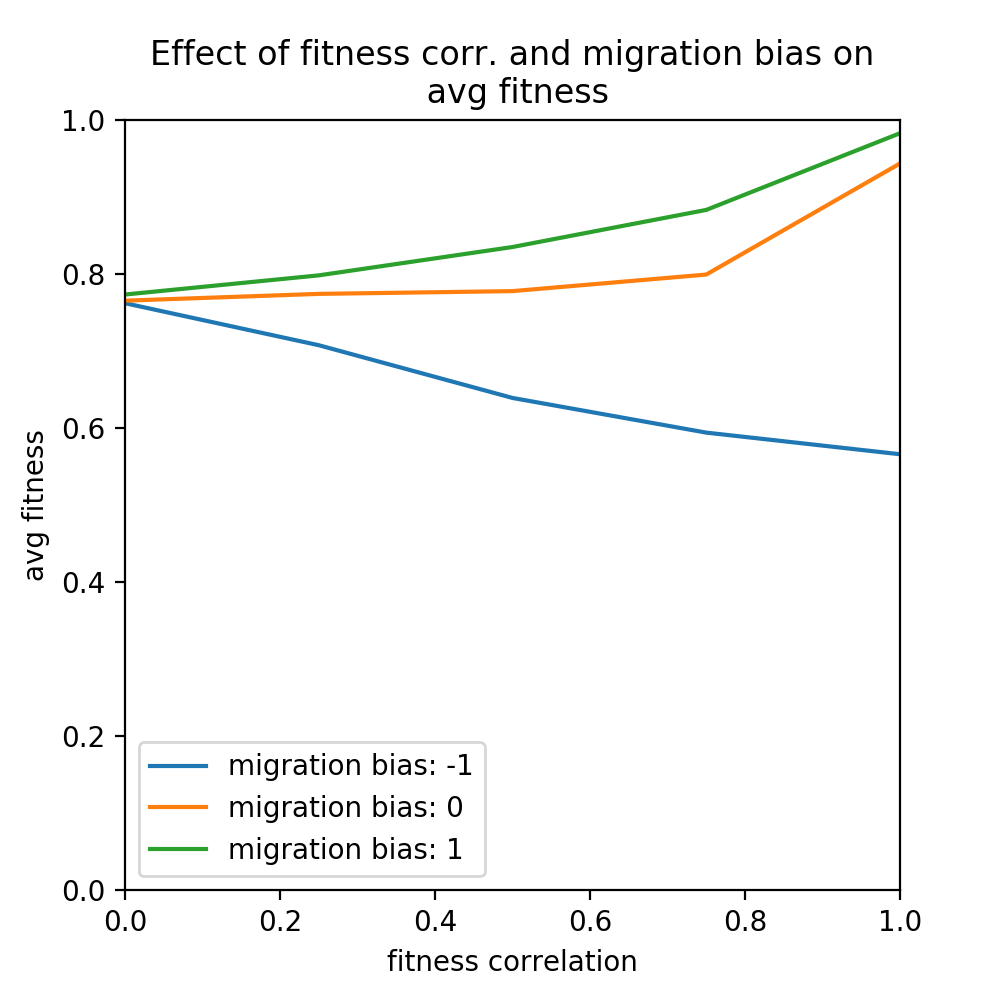

value: 0.00
value: 0.25
value: 0.50
value: 0.75
value: 1.00
value: 0.00
value: 0.25
value: 0.50
value: 0.75
value: 1.00
value: 0.00
value: 0.25
value: 0.50
value: 0.75
value: 1.00
Migration failed from [(0, 9472), (1, 13236), (2, 565), (3, 3444), (4, 4251), (5, 1035), (6, 1652), (7, 3023), (8, 11669), (9, 8991), (10, 16118), (11, 6995), (12, 543), (13, 3350), (14, 6552), (15, 7107), (16, 631), (17, 10587), (18, 11310), (19, 2549), (20, 9575), (21, 6128), (22, 8929), (23, 5533), (24, 281), (25, 14252), (26, 10774), (27, 8316), (28, 3946), (29, 512), (30, 8048), (31, 13770), (32, 5487), (33, 10011), (34, 14157), (35, 9182), (36, 6814), (37, 1231), (38, 1964), (39, 8132), (40, 112), (41, 1935), (42, 15203), (43, 15734), (44, 3709), (45, 9371), (46, 3077), (47, 2284), (48, 14776), (49, 4153)] to [(0, 14252), (1, 281), (2, 15203), (3, 8316), (4, 565), (5, 8048), (6, 7107), (7, 5487), (8, 631), (9, 8132), (10, 3077), (11, 1035), (12, 16118), (13, 112), (14, 13770), (15, 512), (16, 6128), (17

Text(0.5, 1.0, 'Effect of fitness corr. and migration bias on\n avg fitness')

In [8]:
plt.figure(figsize=(5,5))
x = np.linspace(0,1,5)
for i, migration_bias in enumerate([-1,0,1]):
    avg_fitnesses = []
    for value in x:
        print('value: %0.2f' % value)
        l = Lattice((5,5), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=value, migration_bias=migration_bias)
        l.run(1000, collect_data=False)
        avg_fitnesses.append(l.avg_fitness())
    plt.plot(x, avg_fitnesses, label='migration bias: %i' % migration_bias)
plt.xlabel('fitness correlation')
plt.ylabel('avg fitness')
plt.ylim([0,1])
plt.legend()
plt.margins(0)
plt.title('Effect of fitness corr. and migration bias on\n avg fitness')

<IPython.core.display.Javascript object>


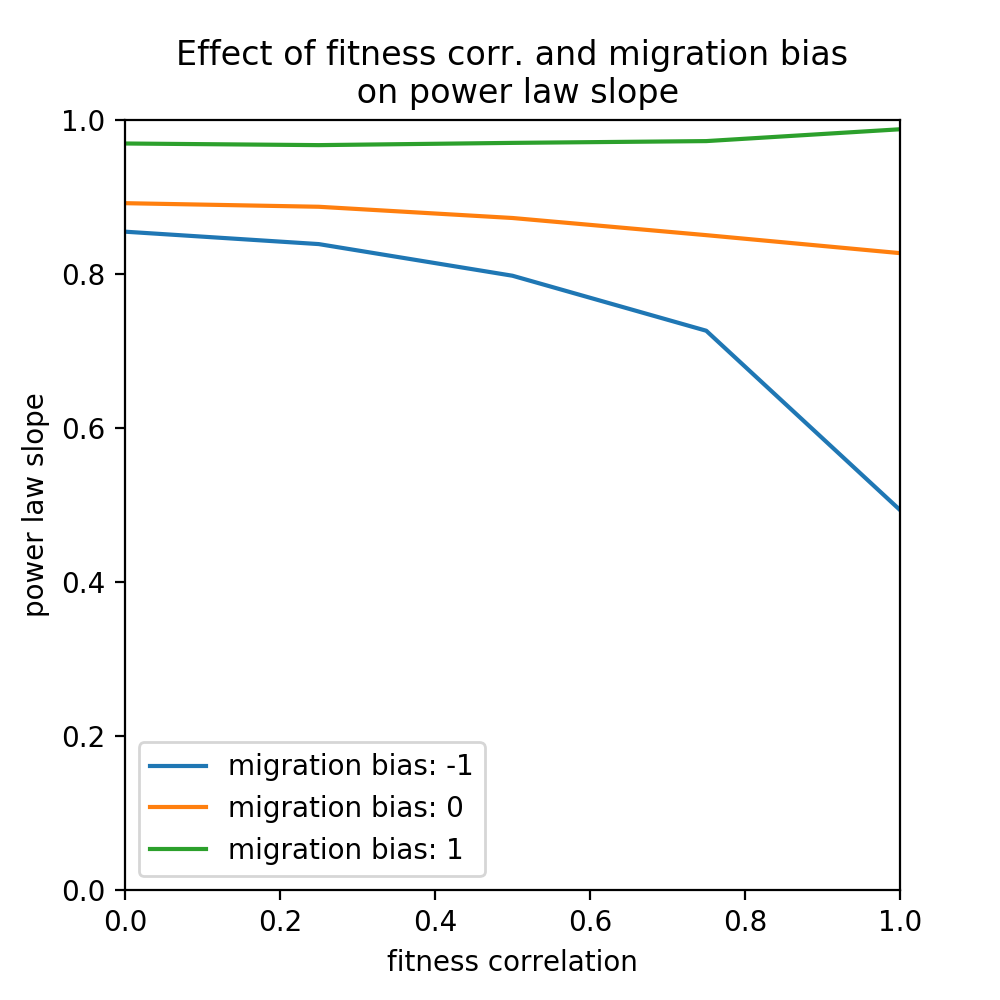

value: 0.00


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:159: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


power: 0.855, MSE: 9.136844944986144e-06
value: 0.25
power: 0.839, MSE: 9.808478508067056e-05
value: 0.50
power: 0.798, MSE: 0.0003899549506924196
value: 0.75
power: 0.726, MSE: 0.0003687786601807934
value: 1.00
power: 0.493, MSE: 0.003328123161203453
value: 0.00
power: 0.892, MSE: 0.0002243127764605522
value: 0.25
power: 0.887, MSE: 0.00022768372580898776
value: 0.50
power: 0.873, MSE: 0.0004665459892856636
value: 0.75
power: 0.85, MSE: 0.00048416612995611966
value: 1.00
power: 0.827, MSE: 0.001065172300496057
value: 0.00
power: 0.969, MSE: 6.920990867500753e-05
value: 0.25
power: 0.967, MSE: 6.515939155568366e-05
value: 0.50
power: 0.97, MSE: 6.239676117074348e-05
value: 0.75
power: 0.973, MSE: 3.0740739062582936e-05
value: 1.00
power: 0.988, MSE: 1.7911080629202402e-06


Text(0.5, 1.0, 'Effect of fitness corr. and migration bias\n on power law slope')

In [81]:
plt.figure(figsize=(5,5))
x = np.linspace(0,1,5)
for i, migration_bias in enumerate([-1,0,1]):
    slopes = []
    for value in x:
        print('value: %0.2f' % value)
        l = Lattice((5,5), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=value, migration_bias=migration_bias)
        l.run(100, collect_data=False)
        slopes.append(l.area_curve('quadrats', plot_bool=False)[0])
        
    plt.plot(x, slopes, label='migration bias: %i' % migration_bias)

plt.xlabel('fitness correlation')
plt.ylabel('power law slope')
plt.ylim([0,1])
plt.legend()
plt.margins(0)
plt.title('Effect of fitness corr. and migration bias\n on power law slope')

In [56]:
l = Lattice((10,10), N=100, network=("watts-strogatz", 3, 0),
            P=0.0001, fitness_correlation=0, migration_bias=0)
l.run(1000, collect_data=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:172: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


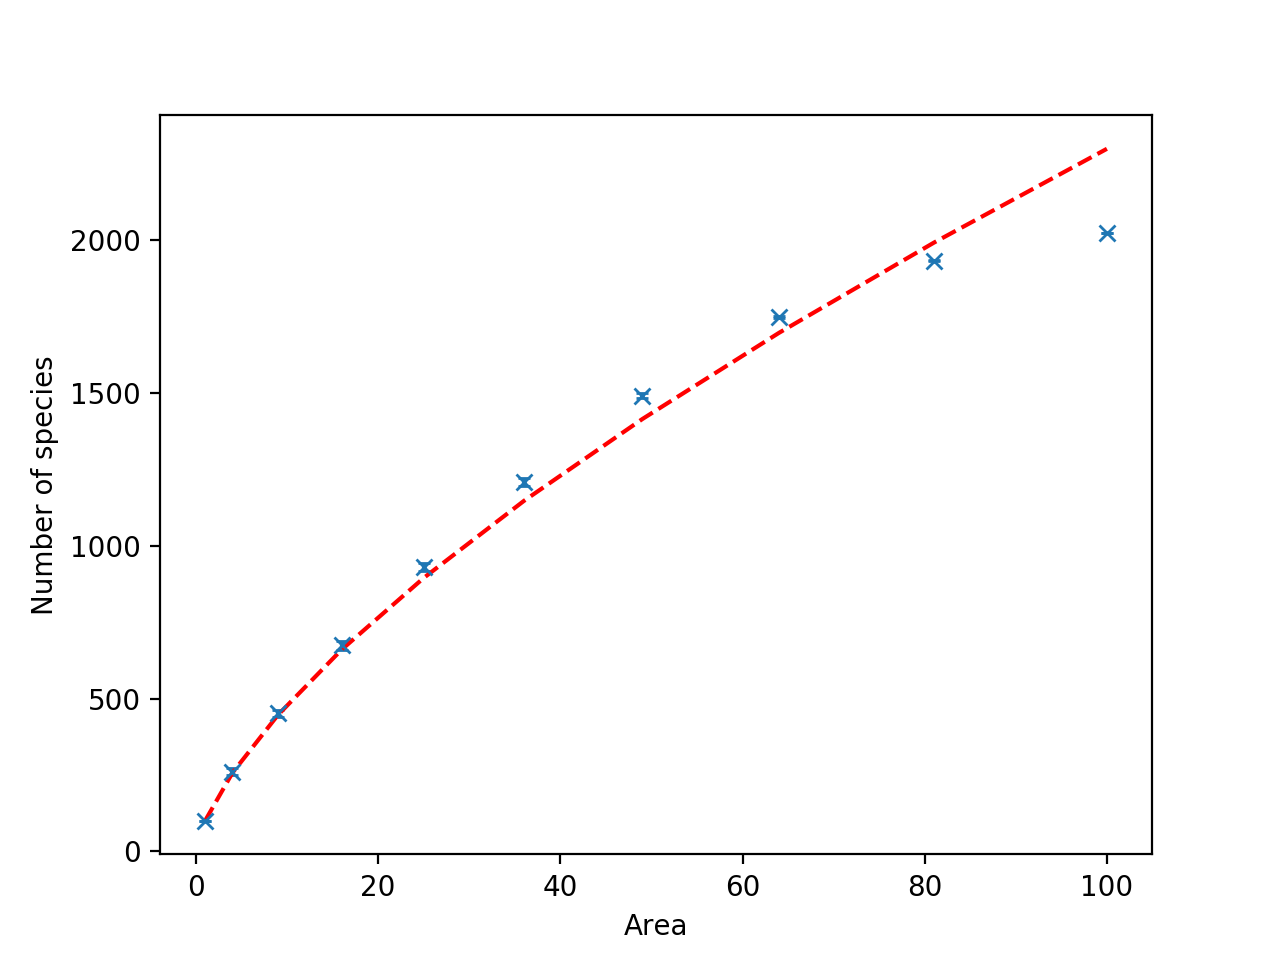

power: 0.681, MSE: 0.004848121472412138


In [57]:
l.area_curve("quadrats", plot_bool=True)
plt.yscale('linear')
plt.xscale('linear')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:172: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


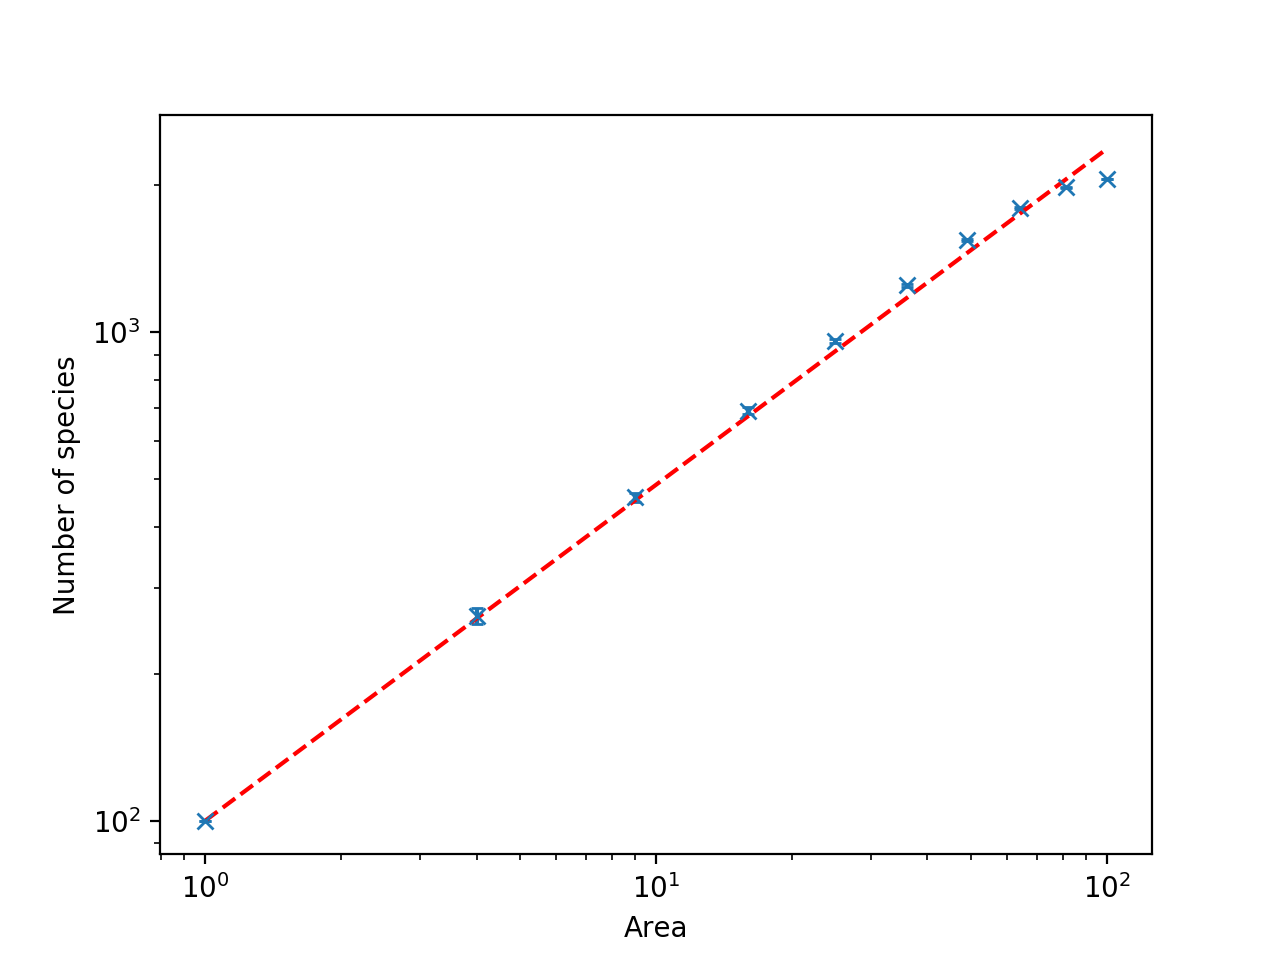

power: 0.688, MSE: 0.006102319800968856


(0.6876957994131367, 0.006102319800968856)

In [55]:
l.area_curve("quadrats", plot_bool=True)

<IPython.core.display.Javascript object>


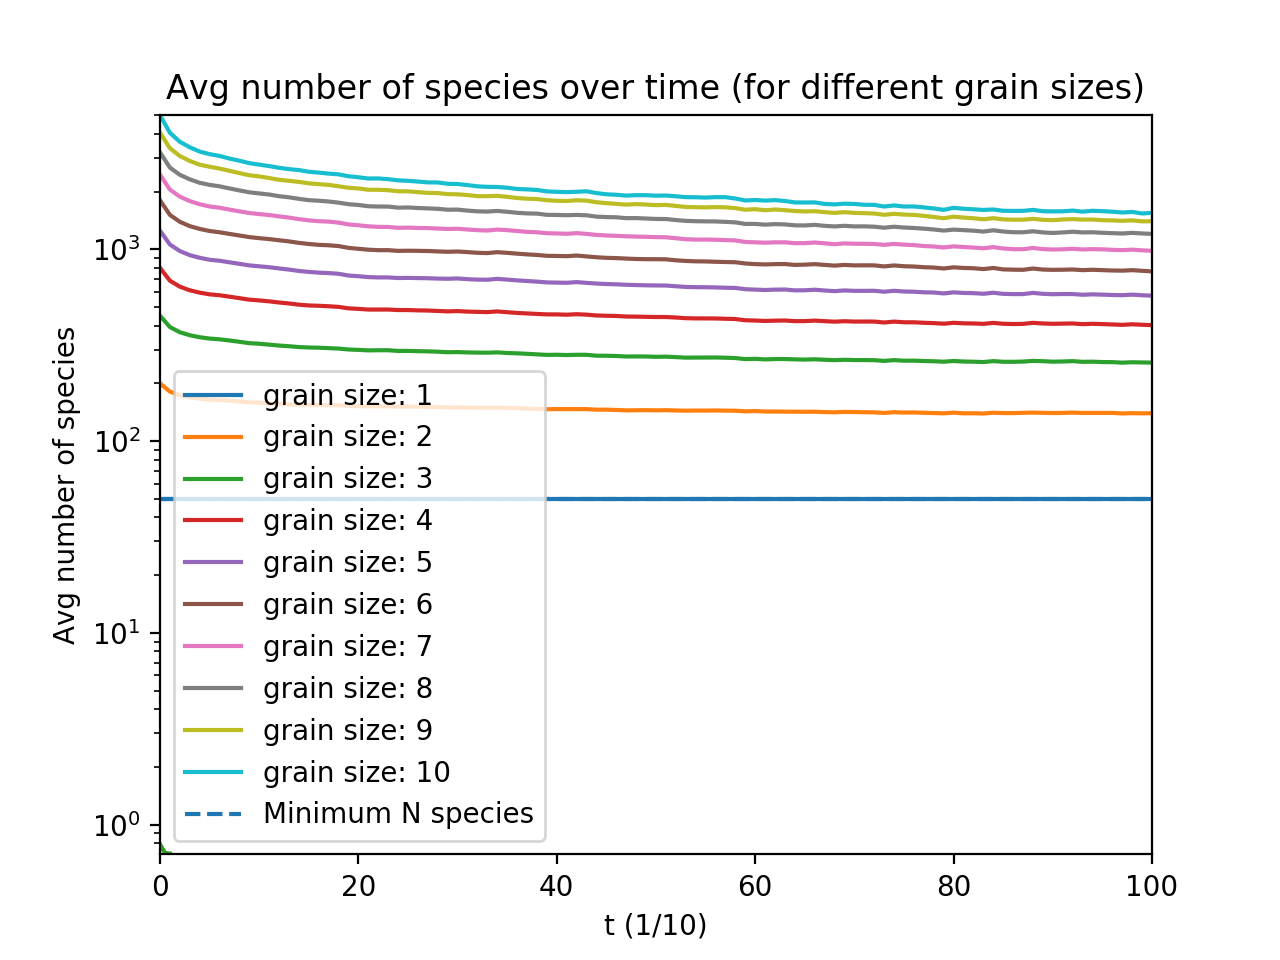

In [9]:
l = Lattice((10,10), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=0, migration_bias=0)
l.run(1000, collect_data=True)
plot_avg_n_species_per_t(l)

In [ ]:
# plot avg_n_species over time for different params

# # grid search
# params = {'fitness_correlation': [0,0.5], 'migration_bias': [0, 0.5]}
# fig = plt.figure(figsize=(8,8))
# k1 = list(params.keys())[0]
# i = 0
# for v1 in params[k1]:
#     k2 = list(params.keys())[1]
#     for v2 in params[k2]:
#         i += 1
#         kwargs = {k1: v1, k2: v2}
#         print(kwargs)
#         Lattice((5,5), N=N, network=("watts-strogatz", 3, 0), P=1/3, **kwargs)
#         l.run(1000, collect_data=True)
#         plt.subplot(2,2,i)
#         plot_avg_n_species_per_t(l, title='%s:%0.2f,\n %s: %0.2f' % (k1, v1, k2,v2))
# plt.tight_layout()

## Area curve over time

<IPython.core.display.Javascript object>


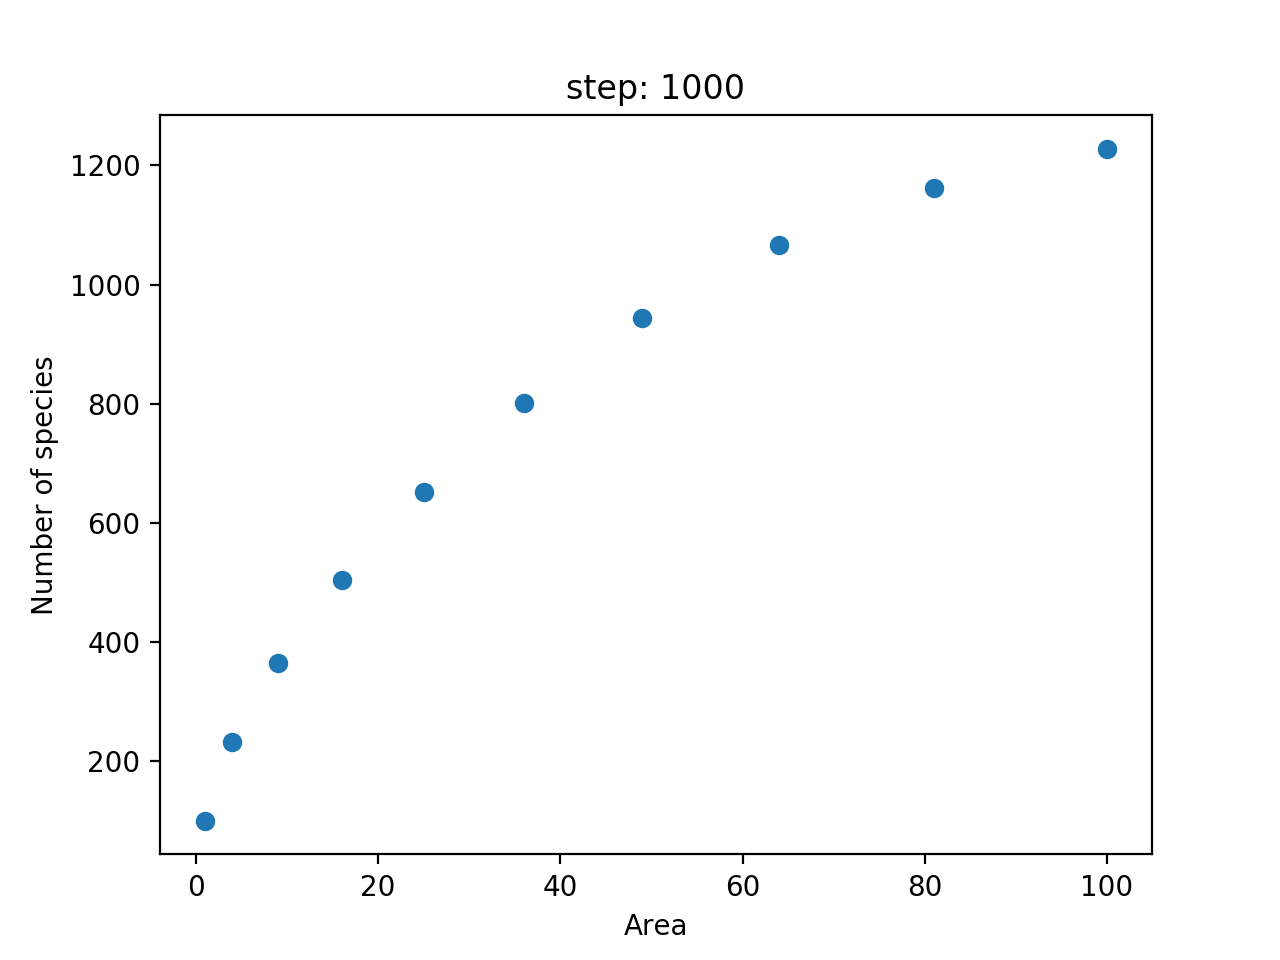

In [8]:
fig, ax = plt.subplots()
line, = ax.plot([],[], "o")
ax.set_xlabel("Area")
ax.set_ylabel("Number of species")
# ax.set_xscale("log")
# ax.set_yscale("log")

step_size = 10

def animate(data):
    step, species = data
    
    ax.set_title("step: {}".format(step * step_size))

    # calculate area curve
    area_curve = collections.OrderedDict()
    for grain_size in range(1, max(l.dimensions)+1):
        means = []
        i = 0
        for interval_i in range(0, l.dimensions[0]-grain_size+1):
            for interval_j in range(0, l.dimensions[1]-grain_size+1):
                unique_species = set()
                for i,j in np.ndindex((grain_size,grain_size)):
                    ii = interval_i + i
                    jj = interval_j + j
                    unique_species = unique_species.union(species[ii,jj])
                    i += 1

                means.append(len(unique_species))

        area_curve[grain_size**2] = np.mean(means)
    line.set_xdata(list(area_curve.keys()))
    line.set_ydata(list(area_curve.values()))

    ax.relim()
    ax.autoscale_view()

    return line

ani = animation.FuncAnimation(fig, animate, enumerate(l.data[::step_size]), interval=100, repeat=False, blit=True, save_count=1000)

## Species migration over lattice

<IPython.core.display.Javascript object>


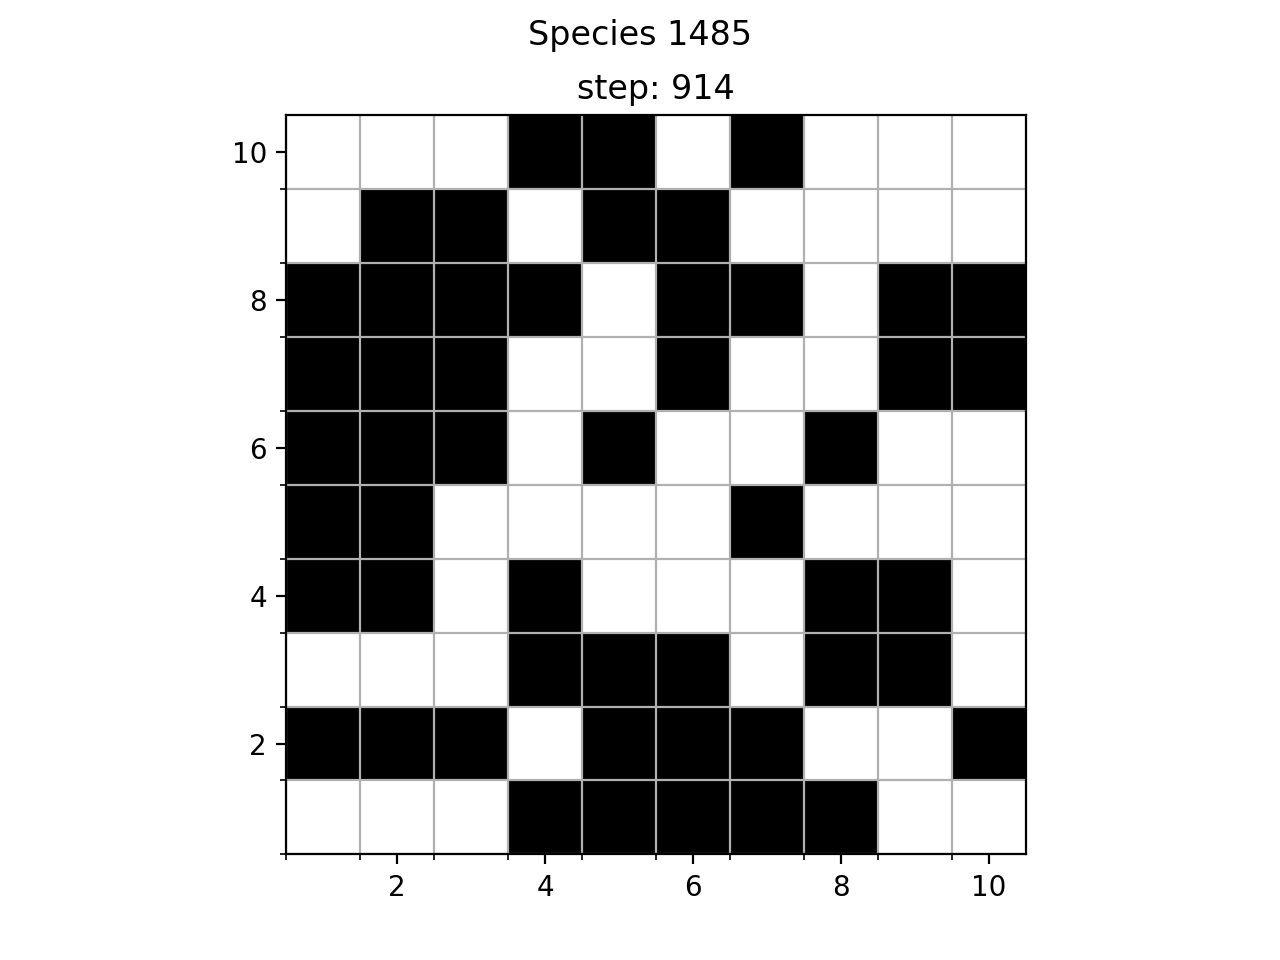

In [9]:
species_count = collections.Counter([x for l in l.data.flatten() for x in l])
spec_id, _ = species_count.most_common(1)[0]

im_data = np.zeros(l.dimensions)

fig, ax = plt.subplots()
im = ax.imshow(im_data, cmap="binary", vmin=0, vmax=1,
               extent=(0.5, l.dimensions[0]+0.5, 0.5, l.dimensions[1]+0.5))
ax.set_xticks(np.arange(l.dimensions[0])+0.5, minor=True)
ax.set_yticks(np.arange(l.dimensions[1])+0.5, minor=True)
ax.grid(True, which="minor")

fig.suptitle("Species {}".format(spec_id))

step_size = 1

def animate(data):
    step, species = data
    
    ax.set_title("step: {}".format(step * step_size))
    
    for i,j in np.ndindex(l.dimensions):
        if spec_id in species[i,j]:
            im_data[i,j] += 0.5
        else:
            im_data[i,j] = 0
    im.set_data(im_data)
    
    return im

ani = animation.FuncAnimation(fig, animate, enumerate(l.data[::step_size]), interval=50, repeat=False, blit=True, save_count=1000)

## Mean number of species over time

<IPython.core.display.Javascript object>


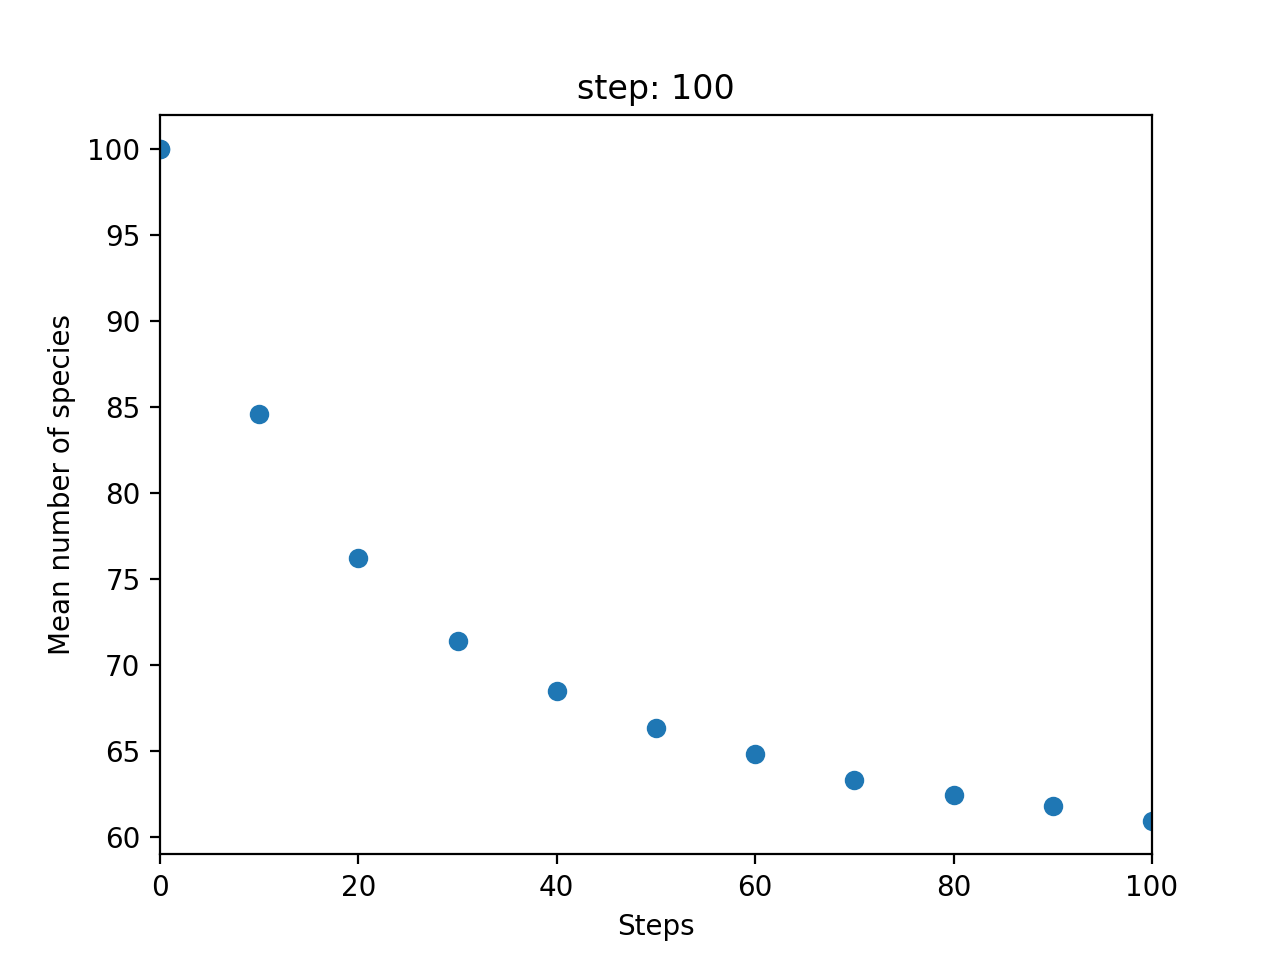

In [10]:
dimensions = (6,6)
l = Lattice(dimensions, 100, ("watts-strogatz", 3, 0), 1/3)
step_size = 10
steps = 10

fig, ax = plt.subplots()
line, = plt.plot([],[], "o")
ax.set_xlim(0, steps*step_size)
ax.set_xlabel("Steps")
ax.set_ylabel("Mean number of species")

def animate(i):
    if i > 0:
        l.run(step_size)

    t = i * step_size
    
    ax.set_title("step: {}".format(t))
    line.set_xdata(np.append(line.get_data()[0], [t]))
    line.set_ydata(np.append(line.get_data()[1], [l.mean_species()]))
    
    ax.relim()
    ax.autoscale_view()
    
    return line

ani = animation.FuncAnimation(fig, animate, np.arange(steps+1), interval=500, repeat=False, blit=True, save_count=1000)

## Parameter testing

In [ ]:
path_slope = "C:/Users/ruuds/aaaaComputational Science/Complex System Simulation/Complex-Systems/Complex-Systems/slope.pkl"
path_pow = "C:/Users/ruuds/aaaaComputational Science/Complex System Simulation/Complex-Systems/Complex-Systems/law.pkl"
path_fit = "C:/Users/ruuds/aaaaComputational Science/Complex System Simulation/Complex-Systems/Complex-Systems/law.pkl"
iters = 10
fitness_correlation_list = np.linspace(0,1,iters)[:5]
migration_bias_list = np.linspace(-1,1,iters)
power_slope = np.zeros((iters, iters))
is_power_law = np.ones((iters, iters))
avg_fitness = np.zeros((iters, iters))

for i, fc in enumerate(fitness_correlation_list):
    for j, mb in enumerate(migration_bias_list):
        print(int(i), int(j))
        l = Lattice((10,10), N=100, network=("watts-strogatz", 3, 0),
                P=1/2, fitness_correlation=fc, migration_bias=mb)
        l.run(3000, collect_data=False)
        power_slope[int(i),int(j)], res = l.area_curve("quadrats",plot_bool=False)
        if (res > 0.015):
            is_power_law[int(i),int(j)] = 0
        avg_fitness[int(i),int(j)] = l.avg_fitness()

    f = open(path_slope,"wb")
    pickle.dump(power_slope,f)
    f.close()
    
    f = open(path_pow,"wb")
    pickle.dump(is_power_law,f)
    f.close()
    
    f = open(path_fit,"wb")
    pickle.dump(avg_fitness,f)
    f.close()

0 0


C:\Users\ruuds\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:160: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


power: 0.67, MSE: 0.002059729068872391
0 1
power: 0.66, MSE: 0.0029292862500503816
0 2
power: 0.676, MSE: 0.0030280926181111595
0 3
power: 0.666, MSE: 0.003338915080632637
0 4
power: 0.673, MSE: 0.002698872518384289
0 5
power: 0.665, MSE: 0.0023909893798596247
0 6
power: 0.662, MSE: 0.0028687251316713556
0 7
power: 0.665, MSE: 0.0038292414821599393
0 8
power: 0.673, MSE: 0.002451947567400884
0 9
power: 0.67, MSE: 0.0024576544223916356
1 0
power: 0.843, MSE: 0.0014400738783531268
1 1


In [82]:
a = pickle.load(open(path_pow, "rb"))

In [89]:
avg_fitness

array([[0.54321722, 0.54209558, 0.5389392 , 0.53787345, 0.55042312,
        0.54265297, 0.54434712, 0.54311797, 0.54777289, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       